## Northwind Traders Analytics

### Exploratory Data Analysis & Advanced Analytics

#### Setup and Load PostgreSQL database
- Connect to PostgreSQL database and load SQL extension
- Perform data exploration to view all base tables
- Create tables with common joins for querying throughout the rest of the project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext sql
%sql postgresql://postgres@localhost:5432/northwind

In [3]:
%%sql

SELECT table_name, table_type 
  FROM information_schema.tables 
 WHERE table_schema = 'public';

 * postgresql://postgres@localhost:5432/northwind
17 rows affected.


table_name,table_type
territories,BASE TABLE
order_details,BASE TABLE
employee_territories,BASE TABLE
us_states,BASE TABLE
customers,BASE TABLE
orders,BASE TABLE
employees,BASE TABLE
shippers,BASE TABLE
products,BASE TABLE
categories,BASE TABLE


In [7]:
%sql employees << SELECT * FROM products
df_employees = employees.DataFrame()
df_employees.info()

 * postgresql://postgres@localhost:5432/northwind
77 rows affected.
Returning data to local variable employees
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         77 non-null     int64  
 1   product_name       77 non-null     object 
 2   supplier_id        77 non-null     int64  
 3   category_id        77 non-null     int64  
 4   quantity_per_unit  77 non-null     object 
 5   unit_price         77 non-null     float64
 6   units_in_stock     77 non-null     int64  
 7   units_on_order     77 non-null     int64  
 8   reorder_level      77 non-null     int64  
 9   discontinued       77 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 6.1+ KB


In [5]:
%%sql 

CREATE OR REPLACE VIEW customer_orders AS 
SELECT c.*, o.order_id, o.employee_id, o.order_date, o.required_date, o.shipped_date, o.ship_via, o.freight, o.ship_name, o.ship_address, o.ship_city, o.ship_region, o.ship_postal_code, o.ship_country
  FROM customers AS c
  JOIN orders AS o 
    ON c.customer_id = o.customer_id;

CREATE OR REPLACE VIEW product_quantity_orders AS
SELECT p.*, od.quantity, od.discount, o.*
  FROM products AS p
  JOIN order_details AS od ON p.product_id = od.product_id
  JOIN orders AS o ON od.order_id = o.order_id
 ORDER BY p.product_id;

CREATE OR REPLACE VIEW employee_orders AS 
SELECT e.last_name, e.first_name, e.title, e.title_of_courtesy, e.birth_date, e.hire_date, address, city, region, postal_code, country, home_phone, extension, notes, reports_to, photo_path, o.*
  FROM employees AS e
  JOIN orders AS o ON e.employee_id = o.employee_id
 ORDER BY o.employee_id;

 * postgresql://postgres@localhost:5432/northwind
Done.
Done.
Done.


[]

#### Employees Sales Performance

- Rank employees based on their total sales amount
- Compare each employee's sales performance to the average sales performance of all employees to evaluate their contributions.

In [6]:
%%sql

WITH aggregate_sales AS(
SELECT e.employee_id, SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_sales
  FROM employees AS e
  JOIN orders AS o ON e.employee_id = o.employee_id
  JOIN order_details AS od ON o.order_id = od.order_id
 GROUP BY e.employee_id)

SELECT employee_id, ROUND(total_sales::numeric,2) AS total_sales, RANK() OVER(ORDER BY total_sales DESC) AS employee_rank,
       ROUND(total_sales::numeric - (SELECT AVG(total_sales)::numeric FROM aggregate_sales),2) AS diff_from_average
  FROM aggregate_sales;

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,total_sales,employee_rank,diff_from_average
4,232890.85,1,92247.18
3,202812.84,2,62169.17
1,192107.60,3,51463.93
2,166537.76,4,25894.08
8,126862.28,5,-13781.39
7,124568.23,6,-16075.44
9,77308.07,7,-63335.60
6,73913.13,8,-66730.54
5,68792.28,9,-71851.39


High performers are employees 4,3,1 and low performers are employees 9,6,5

#### Monthly Sales Trends

- Visualize the progress of the sales and identify trends that might shape the company's future strategies
- Aggregate sales data at a monthly level and calculating a running total of sales by month
- Analyze the month-over-month sales growth rate

In [7]:
%%sql monthly_sales <<

WITH monthly_sales AS (
SELECT DATE_TRUNC('month', order_date) AS order_month, SUM(unit_price * quantity * (1 - discount)) AS monthly_sales
  FROM orders 
  JOIN order_Details ON orders.order_id = order_details.order_id
 GROUP BY order_month
 ORDER BY order_month ASC)

SELECT order_month, ROUND(monthly_sales::numeric,2) AS monthly_sales, 
       ROUND(LAG(monthly_sales) OVER w::numeric,2) AS previous_month_sales,
       ROUND((monthly_sales::numeric -  LAG(monthly_sales) OVER w)::numeric / LAG(monthly_sales) OVER w::numeric * 100,2) AS MoM_growth_rate,
       ROUND(SUM(monthly_sales) OVER w::numeric,2) AS running_total
  FROM monthly_sales
WINDOW w AS (ORDER BY order_month);

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.
Returning data to local variable monthly_sales


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

[Text(9678.166666666666, 0, '1996-07'),
 Text(9709.166666666666, 0, '1996-08'),
 Text(9740.166666666666, 0, '1996-09'),
 Text(9770.166666666666, 0, '1996-10'),
 Text(9801.208333333334, 0, '1996-11'),
 Text(9831.208333333334, 0, '1996-12'),
 Text(9862.208333333334, 0, '1997-01'),
 Text(9893.208333333334, 0, '1997-02'),
 Text(9921.208333333334, 0, '1997-03'),
 Text(9952.208333333334, 0, '1997-04'),
 Text(9982.166666666666, 0, '1997-05'),
 Text(10013.166666666666, 0, '1997-06'),
 Text(10043.166666666666, 0, '1997-07'),
 Text(10074.166666666666, 0, '1997-08'),
 Text(10105.166666666666, 0, '1997-09'),
 Text(10135.166666666666, 0, '1997-10'),
 Text(10166.208333333334, 0, '1997-11'),
 Text(10196.208333333334, 0, '1997-12'),
 Text(10227.208333333334, 0, '1998-01'),
 Text(10258.208333333334, 0, '1998-02'),
 Text(10286.208333333334, 0, '1998-03'),
 Text(10317.208333333334, 0, '1998-04'),
 Text(10347.166666666666, 0, '1998-05')]

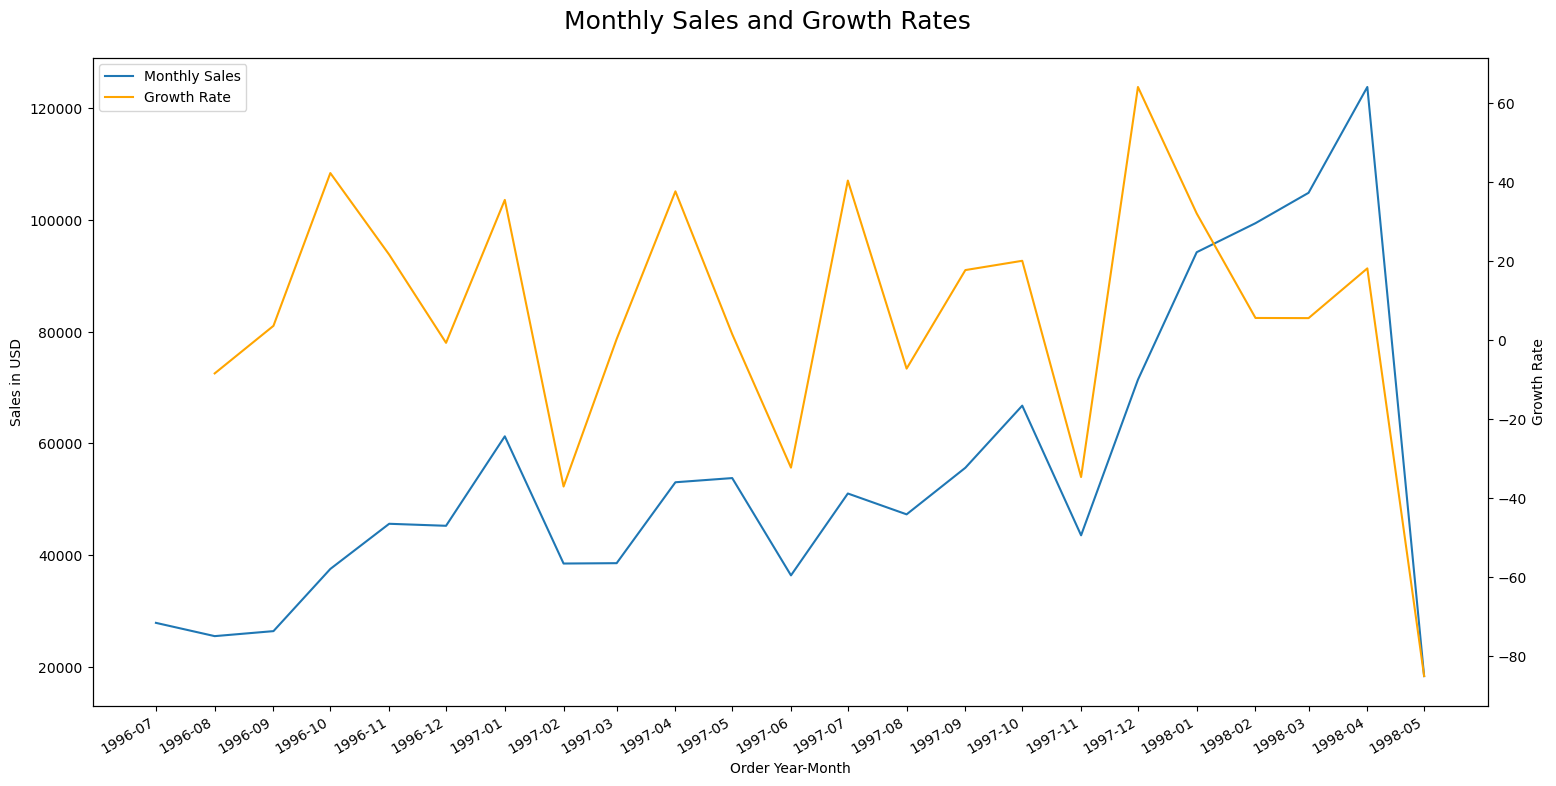

In [8]:
# Save sql query to a dataframe and plot using seaborn to monitor monthly trends in sales and growth rates

df = monthly_sales.DataFrame()

fig,ax = plt.subplots(1,1,figsize=(18,8))
fig.suptitle('Monthly Sales and Growth Rates', fontsize=18)
fig.subplots_adjust(top=0.92)

ax1 = sns.lineplot(x='order_month', y='monthly_sales', data=df, label='Monthly Sales')
ax1.set_ylabel('Sales in USD')
ax1.set_xlabel('Order Year-Month')

ax2 = ax1.twinx()
sns.lineplot(x='order_month', y='mom_growth_rate', data=df, ax=ax2, color='orange', label='Growth Rate')
ax2.invert_yaxis()
ax2.set_ylabel('Growth Rate')

ax1.get_legend().remove()
ax2.get_legend().remove()
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')


df['order_month'] = pd.to_datetime(df['order_month'], utc=True)
ax1.set_xticks(df['order_month'])
ax1.set_xticklabels(df['order_month'].dt.strftime('%Y-%m'), rotation=30, ha='right')



#### High Value Customers
- Identify customers with above-average order values
- Rank customers based on the quantity of above-average orders and highlight the top 5 customers
- Identify the top 20% of customers by total purchase volume.

In [9]:
%%sql

WITH customer_order_totals AS (
SELECT c.customer_id, c.order_id, SUM(o.unit_price * o.quantity * (1 - o.discount)) AS order_total
  FROM customer_orders AS c
  JOIN order_details AS o ON c.order_id = o.order_id
 GROUP BY c.customer_id, c.order_id
 ORDER BY c.customer_id, c.order_id),

order_categorization AS (
SELECT customer_id, order_id, order_total,
       CASE
        WHEN order_total > AVG(order_total) OVER w THEN 'Above Average'
        WHEN order_total <= AVG(order_total) OVER w THEN 'Average/Below Average'
       END AS order_category
  FROM customer_order_totals
WINDOW w AS (ORDER BY order_total RANGE BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)),

customer_ranking AS (
SELECT customer_id, COUNT(DISTINCT order_id) AS above_avg_order_count,
       ROW_NUMBER() OVER(ORDER BY COUNT(DISTINCT order_id) DESC) AS customer_rnk
  FROM order_categorization
 WHERE order_category = 'Above Average'
 GROUP BY customer_id)

SELECT customer_id, above_avg_order_count
  FROM customer_ranking
 WHERE customer_rnk <=5;

 * postgresql://postgres@localhost:5432/northwind
5 rows affected.


customer_id,above_avg_order_count
ERNSH,26
SAVEA,26
QUICK,22
HUNGO,11
RATTC,10


In [10]:
%%sql

WITH customer_percentiles AS (
SELECT c.customer_id, c.company_name, SUM(od.quantity) AS purchase_volume, ROUND(PERCENT_RANK() OVER(ORDER BY SUM(od.quantity) DESC)::numeric,4) AS percentile
  FROM customers AS c
  JOIN orders AS o on c.customer_id = o.customer_id
  JOIN order_details AS od ON o.order_id = od.order_id
 GROUP BY c.customer_id, c.company_name)

SELECT customer_id, company_name, purchase_volume, percentile
  FROM customer_percentiles
 WHERE percentile <= 0.20

 * postgresql://postgres@localhost:5432/northwind
18 rows affected.


customer_id,company_name,purchase_volume,percentile
SAVEA,Save-a-lot Markets,4958,0.0000
ERNSH,Ernst Handel,4543,0.0114
QUICK,QUICK-Stop,3961,0.0227
HUNGO,Hungry Owl All-Night Grocers,1684,0.0341
FRANK,Frankenversand,1525,0.0455
RATTC,Rattlesnake Canyon Grocery,1383,0.0568
FOLKO,Folk och fä HB,1234,0.0682
HILAA,HILARION-Abastos,1096,0.0795
SUPRD,Suprêmes délices,1072,0.0909
WHITC,White Clover Markets,1063,0.1023


#### Product and Category Performance
- Assess the sales composition across different product categories by finding the percent of total sales for each
- Drill down into each group to determine the top three items sold in each product category
- Analyze the cumulative sales for each product category over a specified period to understand each category's growth.
- Identify products that perform exceptionally well in terms of sales. Specifically, products whose total sales exceed the 75th percentile.

In [11]:
%%sql

WITH aggregate_sales AS (
SELECT p.category_id, c.category_name, ROUND(SUM(unit_price * quantity * (1 - discount))::numeric,2) AS total_sales
  FROM product_quantity_orders AS p
  JOIN categories AS c ON p.category_id = c.category_id
 GROUP BY p.category_id, c.category_name
 ORDER BY total_sales DESC)

SELECT category_id, category_name, total_sales, ROUND(total_sales / (SELECT SUM(total_sales) FROM aggregate_sales) * 100.0,2) AS perc_of_total,
       SUM(total_sales) OVER(ORDER BY total_sales DESC) AS running_total,
       SUM(ROUND(total_sales / (SELECT SUM(total_sales) FROM aggregate_sales) * 100.0,2)) OVER(ORDER BY total_sales DESC) AS running_percent
  FROM aggregate_sales
 ORDER BY total_sales DESC;

 * postgresql://postgres@localhost:5432/northwind
8 rows affected.


category_id,category_name,total_sales,perc_of_total,running_total,running_percent
1,Beverages,288694.65,21.33,288694.65,21.33
4,Dairy Products,251147.60,18.56,539842.25,39.89
3,Confections,179863.65,13.29,719705.90,53.18
6,Meat/Poultry,174622.55,12.90,894328.45,66.08
8,Seafood,137989.31,10.20,1032317.76,76.28
2,Condiments,113692.19,8.40,1146009.95,84.68
7,Produce,105745.70,7.81,1251755.65,92.49
5,Grains/Cereals,101646.94,7.51,1353402.59,100.00


The most popular product categories are beverages, dairy products and confections which make up 53.18% of all sales ($719,705.90)

In [12]:
%%sql

WITH sales_by_product AS (
SELECT c.category_name, p.product_name, ROUND(SUM(unit_price * quantity * (1 - discount))::numeric,2) AS total_sales,
       ROW_NUMBER() OVER(PARTITION BY c.category_name ORDER BY SUM(unit_price * quantity * (1 - discount))::numeric DESC) AS product_ranking
  FROM product_quantity_orders AS p
  JOIN categories AS c ON p.category_id = c.category_id
 GROUP BY 1,2)

SELECT category_name, product_name, total_sales
  FROM sales_by_product
 WHERE product_ranking <= 3

 * postgresql://postgres@localhost:5432/northwind
24 rows affected.


category_name,product_name,total_sales
Beverages,Côte de Blaye,153897.17
Beverages,Ipoh Coffee,25109.10
Beverages,Chang,17719.40
Condiments,Vegie-spread,18343.62
Condiments,Sirop d'érable,15022.35
Condiments,Louisiana Fiery Hot Pepper Sauce,14893.93
Confections,Tarte au sucre,50737.09
Confections,Sir Rodney's Marmalade,24199.56
Confections,Gumbär Gummibärchen,21662.69
Dairy Products,Raclette Courdavault,76683.75


In [13]:
%%sql category_sales <<

WITH monthly_sales_by_category AS (
SELECT TO_CHAR(DATE_TRUNC('month', order_date),'YYYY-MM') AS order_month, c.category_name, ROUND(SUM(p.unit_price * od.quantity * (1 - od.discount))::numeric,2) AS total_sales
  FROM categories AS c
  JOIN products AS p ON c.category_id = p.category_id
  JOIN order_details AS od ON p.product_id = od.product_id
  JOIN orders AS o ON od.order_id = o.order_id
 GROUP BY c.category_name, order_month
 ORDER BY order_month)

SELECT order_month, category_name, total_sales, LAG(total_sales) OVER w1 AS previous_month_sales, ROUND((total_sales - LAG(total_sales) OVER w1) / LAG(total_sales) OVER w1 * 100.0,2) AS growth_rate
  FROM monthly_sales_by_category
WINDOW w1 AS (PARTITION BY category_name ORDER BY order_month)

 * postgresql://postgres@localhost:5432/northwind
184 rows affected.
Returning data to local variable category_sales


In [14]:
# Save sql query to a dataframe and plot using seaborn to monitor monthly trends in sales and growth rates
df = category_sales.DataFrame()
df

,order_month,category_name,total_sales,previous_month_sales,growth_rate
0,1996-07,Beverages,3978.12,None,None
1,1996-08,Beverages,6083.60,3978.12,52.93
2,1996-09,Beverages,6360.50,6083.60,4.55
3,1996-10,Beverages,10234.20,6360.50,60.90
4,1996-11,Beverages,21452.57,10234.20,109.62
...,...,...,...,...,...
179,1998-01,Seafood,13798.23,5907.17,133.58
180,1998-02,Seafood,11281.12,13798.23,-18.24
181,1998-03,Seafood,9316.54,11281.12,-17.41
182,1998-04,Seafood,9337.14,9316.54,0.22


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

[Text(9678.0, 0, '1996-07'),
 Text(9709.0, 0, '1996-08'),
 Text(9740.0, 0, '1996-09'),
 Text(9770.0, 0, '1996-10'),
 Text(9801.0, 0, '1996-11'),
 Text(9831.0, 0, '1996-12'),
 Text(9862.0, 0, '1997-01'),
 Text(9893.0, 0, '1997-02'),
 Text(9921.0, 0, '1997-03'),
 Text(9952.0, 0, '1997-04'),
 Text(9982.0, 0, '1997-05'),
 Text(10013.0, 0, '1997-06'),
 Text(10043.0, 0, '1997-07'),
 Text(10074.0, 0, '1997-08'),
 Text(10105.0, 0, '1997-09'),
 Text(10135.0, 0, '1997-10'),
 Text(10166.0, 0, '1997-11'),
 Text(10196.0, 0, '1997-12'),
 Text(10227.0, 0, '1998-01'),
 Text(10258.0, 0, '1998-02'),
 Text(10286.0, 0, '1998-03'),
 Text(10317.0, 0, '1998-04'),
 Text(10347.0, 0, '1998-05'),
 Text(9678.0, 0, '1996-07'),
 Text(9709.0, 0, '1996-08'),
 Text(9740.0, 0, '1996-09'),
 Text(9770.0, 0, '1996-10'),
 Text(9801.0, 0, '1996-11'),
 Text(9831.0, 0, '1996-12'),
 Text(9862.0, 0, '1997-01'),
 Text(9893.0, 0, '1997-02'),
 Text(9921.0, 0, '1997-03'),
 Text(9952.0, 0, '1997-04'),
 Text(9982.0, 0, '1997-05'),
 T

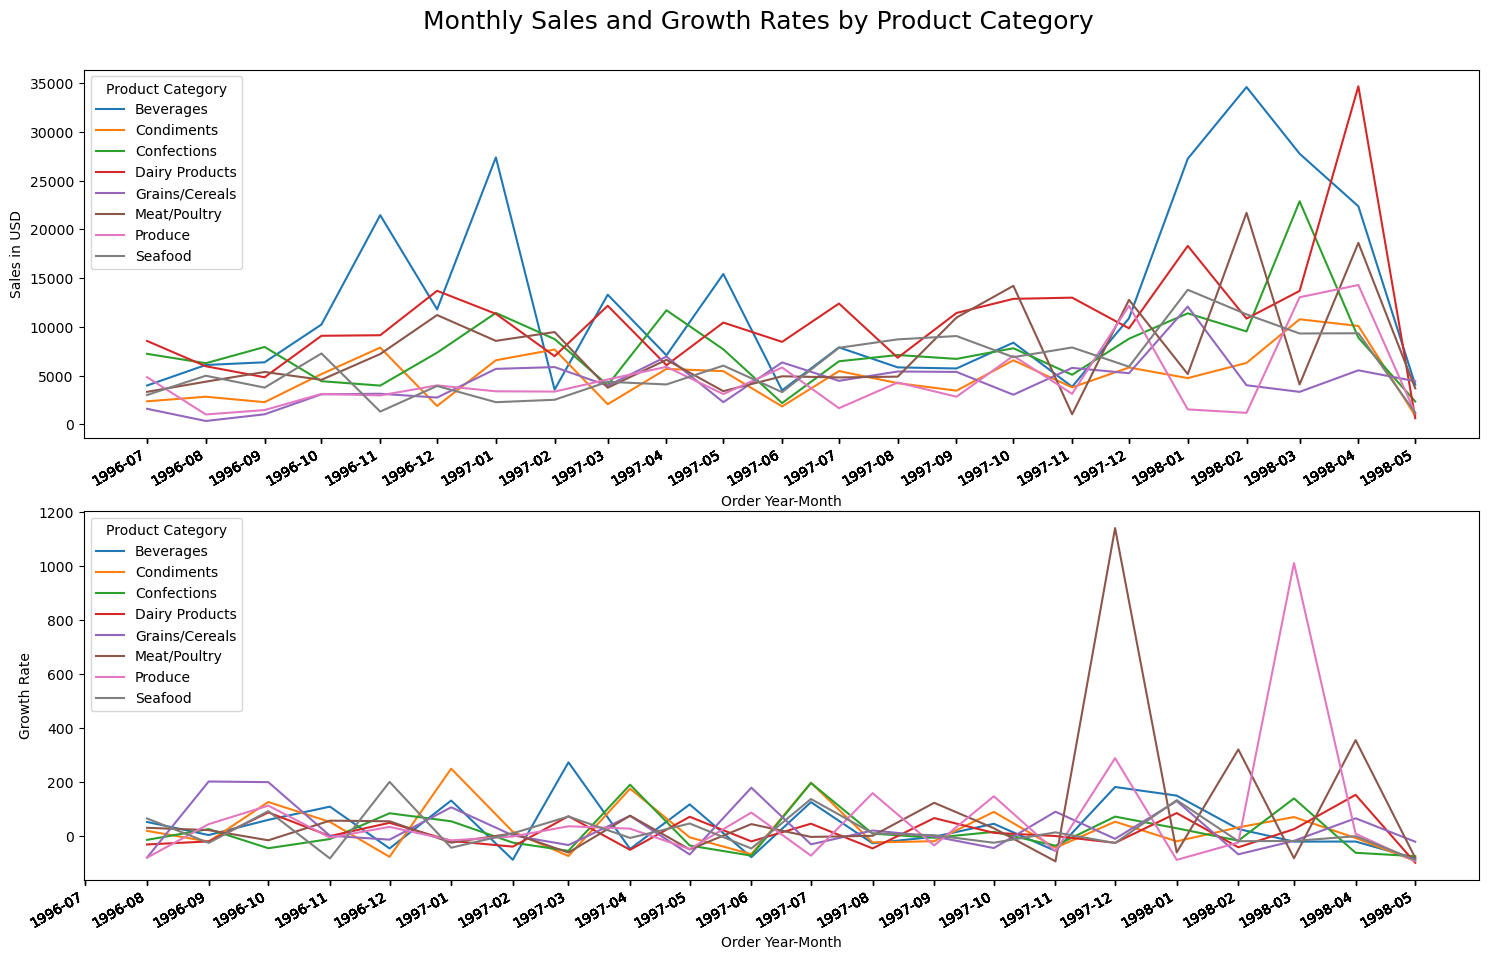

In [59]:
fig,ax = plt.subplots(2,1,figsize=(18,10))
fig.suptitle('Monthly Sales and Growth Rates by Product Category', fontsize=18)
fig.subplots_adjust(top=0.92)

ax1 = sns.lineplot(x='order_month', y='total_sales', hue='category_name', data=df, ax=ax[0])
ax1.set_ylabel('Sales in USD')
ax1.set_xlabel('Order Year-Month')
ax1.legend(title='Product Category')

ax2 = sns.lineplot(x='order_month', y='growth_rate', hue='category_name', data=df, ax=ax[1])
ax2.invert_yaxis()
ax2.set_ylabel('Growth Rate')
ax2.set_xlabel('Order Year-Month')
ax2.legend(title='Product Category')

df['order_month'] = pd.to_datetime(df['order_month'], utc=True)
ax1.set_xticks(df['order_month'])
ax1.set_xticklabels(df['order_month'].dt.strftime('%Y-%m'), rotation=30, ha='right')
ax2.set_xticks(df['order_month'])
ax2.set_xticklabels(df['order_month'].dt.strftime('%Y-%m'), rotation=30, ha='right')


In [ ]:
%%sql

WITH product_percentiles AS (
SELECT c.category_name, p.product_name, ROUND(SUM(unit_price * quantity * (1 - discount))::numeric,2) AS total_sales,
       ROUND(PERCENT_RANK() OVER(ORDER BY SUM(unit_price * quantity * (1 - discount)))::numeric,4) AS product_percentile
  FROM product_quantity_orders AS p
  JOIN categories AS c ON p.category_id = c.category_id
 GROUP BY 1,2)

SELECT product_name, total_sales
  FROM product_percentiles
 WHERE product_percentile <= 0.25

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


product_name,total_sales
Chocolade,1554.86
Genen Shouyu,1561.95
Geitost,1818.00
Laughing Lumberjack Lager,2407.30
Longlife Tofu,2812.50
Gravad lax,2891.20
Aniseed Syrup,3240.00
Filo Mix,3341.45
Valkoinen suklaa,3741.56
Louisiana Hot Spiced Okra,3893.00


### Statistical Analysis & Visualization

In [76]:
%%sql total_orders <<

SELECT c.category_id, c.category_name, p.product_id, p.product_name, od.unit_price, od.quantity, od.discount, (od.unit_price * od.quantity * (1-od.discount)) AS net_total,
       o.order_id, o.order_date, o.customer_id, c1.company_name AS customer_name, c1.country AS customer_country, s.company_name AS supplier_name, s.country AS supplier_country,
       e.country AS employee_country
  FROM categories AS c
  JOIN products AS p ON c.category_id = p.category_id
  JOIN suppliers AS s ON p.supplier_id = s.supplier_Id
  JOIN order_details AS od ON p.product_id = od.product_id
  JOIN orders AS o ON od.order_id = o.order_id
  JOIN customers AS c1 ON o.customer_id = c1.customer_id
  JOIN employees AS e ON o.employee_id = e.employee_id

 * postgresql://postgres@localhost:5432/northwind
2155 rows affected.
Returning data to local variable total_orders


In [77]:
df1 = total_orders.DataFrame()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category_id       2155 non-null   int64  
 1   category_name     2155 non-null   object 
 2   product_id        2155 non-null   int64  
 3   product_name      2155 non-null   object 
 4   unit_price        2155 non-null   float64
 5   quantity          2155 non-null   int64  
 6   discount          2155 non-null   float64
 7   net_total         2155 non-null   float64
 8   order_id          2155 non-null   int64  
 9   order_date        2155 non-null   object 
 10  customer_id       2155 non-null   object 
 11  customer_name     2155 non-null   object 
 12  customer_country  2155 non-null   object 
 13  supplier_name     2155 non-null   object 
 14  supplier_country  2155 non-null   object 
 15  employee_country  2155 non-null   object 
dtypes: float64(3), int64(4), object(9)
memory 

<Axes: xlabel='supplier_country', ylabel='net_total'>

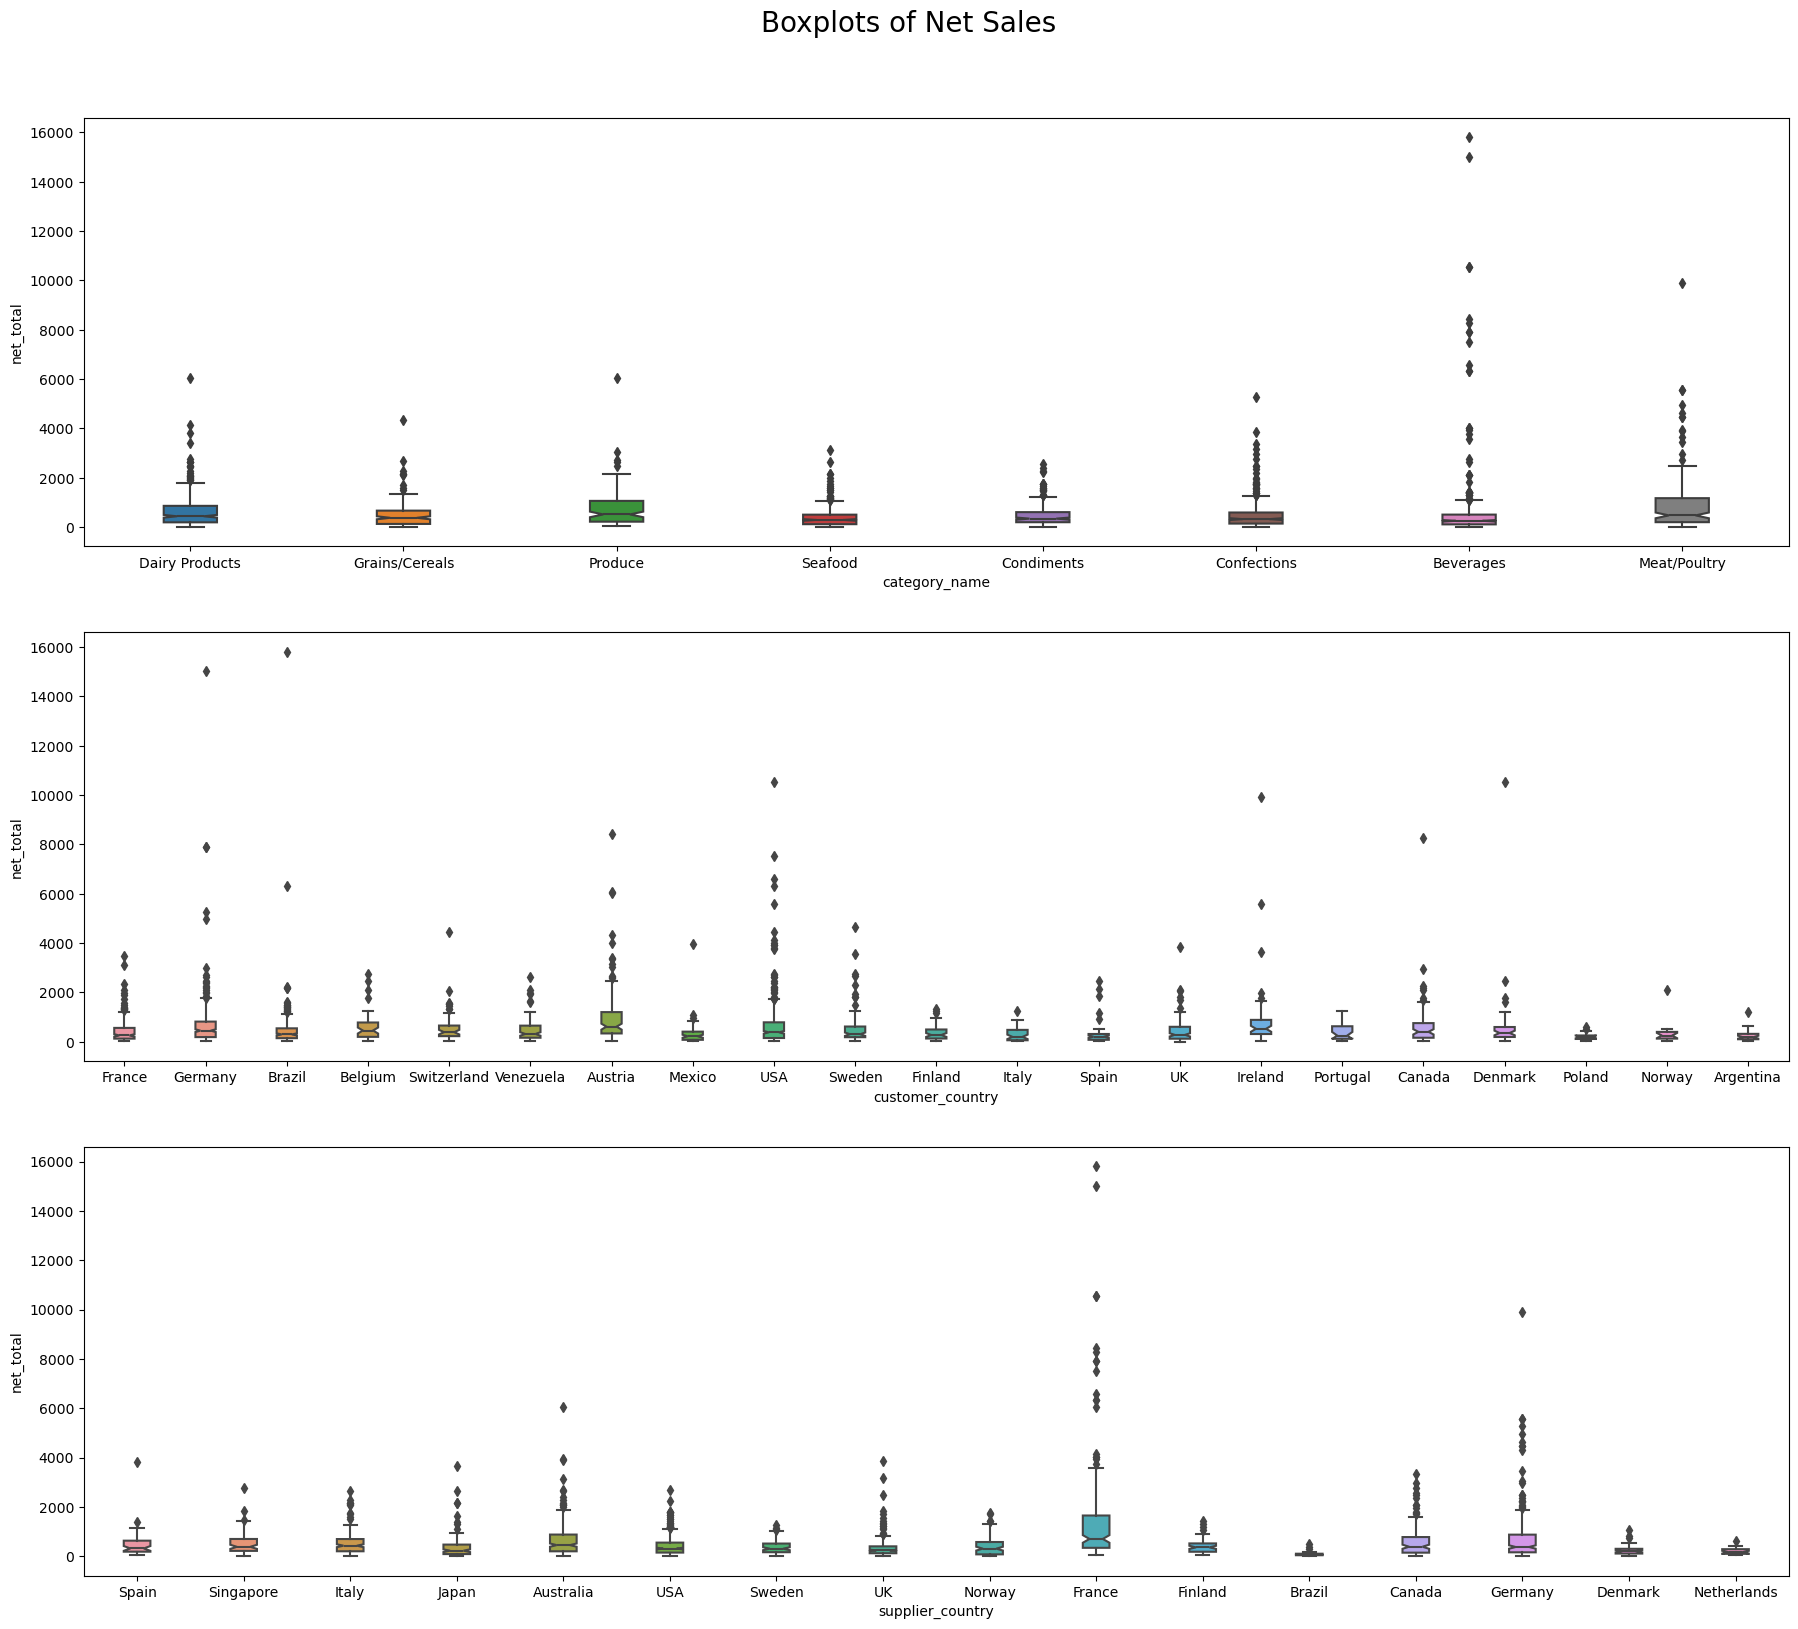

In [83]:
#Create boxplot to show distribution by category
fig,ax = plt.subplots(3,1,figsize=(22,18))
fig.suptitle('Boxplots of Net Sales', fontsize=20)
fig.subplots_adjust(top=0.92)

sns.boxplot(data=df1, y='net_total', x='category_name', ax=ax[0], notch=True, showmeans=False, width=0.25)
sns.boxplot(data=df1, y='net_total', x='customer_country', ax=ax[1], notch=True, showmeans=False, width=0.25)
sns.boxplot(data=df1, y='net_total', x='supplier_country', ax=ax[2], notch=True, showmeans=False, width=0.25)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/gw/_4_wlzp97m17tx2mr76pbb_m0000gn/T/ipykernel_1421/3941733924.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df1['customer_country'].unique(), rotation=30, ha='right', fontsize=10)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

[Text(0, 0, 'UK'), Text(1, 0, 'USA')]

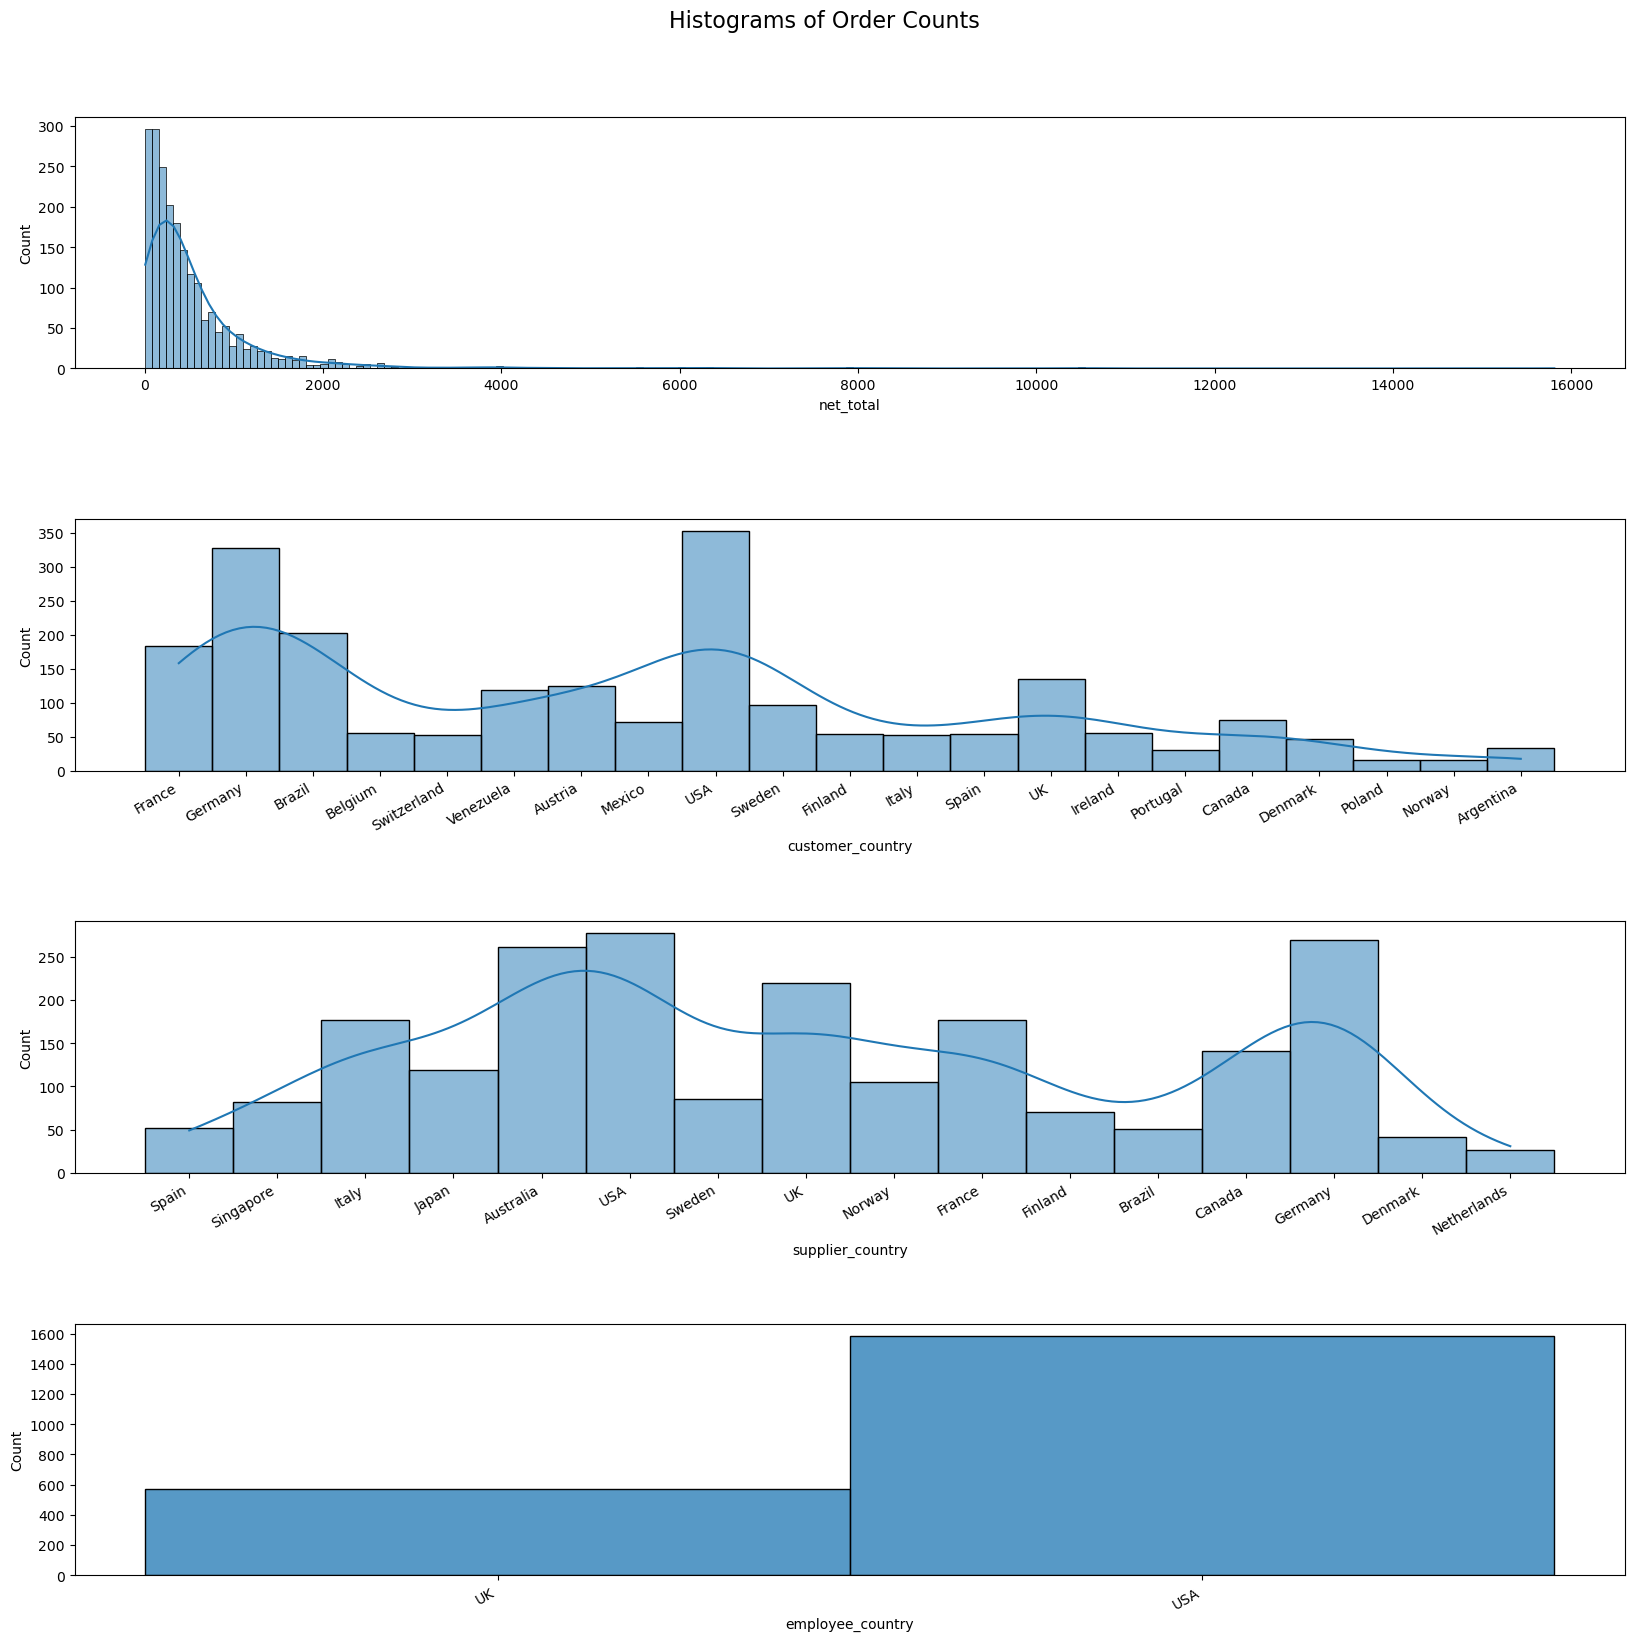

In [82]:
#Create histograms to show distribution of continuous variables
fig,ax = plt.subplots(4,1,figsize=(20,18))
fig.suptitle('Histograms of Order Counts', fontsize=16)
fig.subplots_adjust(top=0.92)


sns.histplot(data=df1,x='net_total',ax=ax[0], multiple='dodge', kde=True)
sns.histplot(data=df1,x='customer_country',ax=ax[1], multiple='dodge', kde=True)
ax[1].set_xticklabels(df1['customer_country'].unique(), rotation=30, ha='right', fontsize=10)
sns.histplot(data=df1, x='supplier_country', ax=ax[2], multiple='dodge', kde=True)
ax[2].set_xticklabels(df1['supplier_country'].unique(), rotation=30, ha='right', fontsize=10)
plt.subplots_adjust(hspace=0.6)
sns.histplot(data=df1, x='employee_country', ax=ax[3], multiple='dodge', kde=False)
ax[3].set_xticklabels(df1['employee_country'].unique(), rotation=30, ha='right', fontsize=10)